## Set up environement

In [1]:
from os import path, makedirs
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [2]:
%load_ext autoreload
%autoreload 2
from parameters import *
from forward_model import *

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
makedirs(wd+"results/", exist_ok=True)
makedirs(wd+"RUN_SCRIPTS/", exist_ok=True)

## Perform some compute node -related tests

### Simple forward pass

In [ ]:
script1_path = wd+"simple_forward_pass.py"

In [ ]:
%%writetemplate {script1_path}
print("Loading libraries...")
from parameters import *
from forward_model import *
from matplotlib import pyplot as plt
import seaborn as sns
print("Done. Initializing BiasModelBORG for data_seed=0...")
BiasModel = BiasModelBORG("bias::BrokenPowerLaw")
print("Done. Performing forward pass for res=256...")
i = 3
parameters = np.array([2.5, 0.65, 1.5, 0.4])
count = BiasModel.get_count_field(i, parameters)
N = BiasModelBORG.get_N(BiasModel, i)
print("Done. Plotting slice_ref...")
slice_ref = count[:,:,N//2]
sns.heatmap(slice_ref)
plt.savefig(wd+"results/slice_ref.png")
print("Done. Saving slice_ref...")
np.save(wd+"results/slice_ref.npy", slice_ref)
print("Done.")

In [ ]:
%%writetemplate {wd+"RUN_SCRIPTS/run1.sh"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script1_path}"
exit 0

In [ ]:
%%bash -s {wd+"RUN_SCRIPTS/run1.sh"}
qsub $1

One has to wait for the job launched above to finish before being able to run the following cell.

In [ ]:
slice_ref = np.load(wd+"results/slice_ref.npy")
# sns.heatmap(slice_ref) ; plt.show()

### Checks computation of errors

In [ ]:
script2_path = wd+"checks_errors.py"

In [ ]:
%%writetemplate {wd+"RUN_SCRIPTS/run2.sh"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script2_path}"
exit 0

In [ ]:
%%bash -s {wd+"RUN_SCRIPTS/run2.sh"}
qsub $1

## Optimisation for small parameters space

### Exploration

#### Checks varying the number of resolutions

In [ ]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw")
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

In [ ]:
# Should yield the same as the above cell
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_3"])
i = 0
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

In [ ]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"])
i = 0
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

#### Checks varying the number of mass bins considered

In [ ]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

#### Checks varying the data seed

In [ ]:
# Should yield the same as the above cell:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
BiasModel.load_data(0)
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

In [ ]:
# Should be slightly different:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
BiasModel.load_data(1)
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

#### Error on full dataset

In [ ]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[2.5, 0.65, 1.5, 0.4]]*2]*2)
err = BiasModel.compute_error(parameters_list)
print(err)

In [ ]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[1, 1, 1, 1]]*2]*2)
err = BiasModel.compute_error(parameters_list)
print(err)

In [ ]:
BiasModel = BiasModelBORG("bias::Linear", reskeys=["res_0", "res_1", "res_2"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[1, 1]]*2]*3)
err = BiasModel.compute_error(parameters_list)
print(err)

#### Sequential computation of the total loss

##### Most complex case (all resolutions, all mass bins)

In [ ]:
script3_path = wd+"try_full_loss_v1.py"

In [ ]:
%%writetemplate {wd+"RUN_SCRIPTS/run3.sh"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script3_path}"
exit 0

In [ ]:
%%bash -s {wd+"RUN_SCRIPTS/run3.sh"}
qsub $1

Poisson:
```bash
####################
Computing error for bias model: bias::Linear
Error: 5.424980806430816
Time: 19.747969150543213
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 5.630357691003928
Time: 16.98229718208313
####################
Computing error for bias model: bias::SecondOrderBias
Error: 4.947548507437198
Time: 61.746253967285156
```

MSE:
```bash
####################
Computing error for bias model: bias::Linear
Error: 5.424980806430816
Time: 21.32629084587097

####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 5.630357691003928
Time: 31.602696895599365

####################
Computing error for bias model: bias::SecondOrderBias
Error: 4.947548507437198
Time: 78.03321027755737
```

##### Easy case (one resolution, two mass bins)

In [ ]:
script4_path = wd+"try_full_loss_v2.py"

In [ ]:
%%writetemplate {wd+"RUN_SCRIPTS/run4.sh"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script4_path}"
exit 0

In [ ]:
%%bash -s {wd+"RUN_SCRIPTS/run4.sh"}
qsub $1

Poisson:
```bash
####################
Computing error for bias model: bias::Linear
Error: -10303.13282692553
Time: 0.45497822761535645
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: -259920.0763539538
Time: 0.08563613891601562
####################
Computing error for bias model: bias::SecondOrderBias
Error: 9296010.143621296
Time: 0.6990132331848145
```

MSE:
```bash
####################
Computing error for bias model: bias::Linear
Error: 12.92336057566297
Time: 0.7955682277679443
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 12.617381975535864
Time: 0.1658039093017578
####################
Computing error for bias model: bias::SecondOrderBias
Error: 13.262693839300717
Time: 0.7903237342834473
```

### Perform optimisation in the simple case (dim 4 / dim 8 parameter space)

In [ ]:
bias_model = "bias::BrokenPowerLaw"
# bias_model = "bias::SecondOrderBias"
# bias_model = "bias::Linear"

reskeys=["res_0"]
fields_to_load=['dm_overdensity', 'counts_bin_0']
# fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1']
nkeys = len(reskeys)
nfields = len(fields_to_load)-1
parameters_list_dict = {"bias::Linear": np.array([[[1, 1]]*nfields]*nkeys),
                        # "bias::BrokenPowerLaw": np.array([[[1,1,1,1]]*nfields]*nkeys),
                        "bias::BrokenPowerLaw": np.array([[[2.5, 0.65, 1.5, 0.4]]*nfields]*nkeys),
                        "bias::SecondOrderBias": np.array([[[1, 1, 1, 1]]*nfields]*nkeys)}

# TODO: define the correct physical bounds for the parameters:
bounds = {"bias::Linear": [(1., 500.), (0.01, 3.)]*nfields,
            "bias::BrokenPowerLaw": [(1., 500.), (0.01, 3.), (.01, 2.), (.01, 2.)]*nfields,
            "bias::SecondOrderBias": [(1., 500.), (0.01, 3.), (.01, 2.), (.01, 2.)]*nfields}

BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
parameters_list = parameters_list_dict[bias_model]
err = BiasModel.compute_error(parameters_list, loss="Poisson")
print(err)

In [ ]:
def error_function(parameters_list_flat):
    parameters_list = parameters_list_flat.reshape((nkeys, nfields, -1))
    return BiasModel.compute_error(parameters_list, loss="Poisson")

# The callback function is only used to print the parameters and the error at each iteration:
def callback_function(parameters_list_flat):
    parameters_list = parameters_list_flat.reshape((nkeys, nfields, -1))
    err = BiasModel.compute_error(parameters_list, loss="Poisson")
    print("Parameters: {}".format(parameters_list))
    print("Loss: {}".format(err))

initial_guess = parameters_list.flatten()

from scipy.optimize import minimize
res = minimize(error_function, initial_guess, method="L-BFGS-B", callback=callback_function,
               tol=1e-10,
               bounds=bounds[bias_model],
               options={'disp': True, 'eps':1e-5, 'finite_diff_rel_step': 1e-5})

print(res)

In [ ]:
# Visualize the predictions with the optimized parameters:
BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
params = res.x.reshape((nkeys, nfields, -1))
BiasModel.plot_count_field(0, params[0][0], "counts_bin_0")

In [ ]:
# Visualize the predictions with the initial parameters:
BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
BiasModel.plot_count_field(0, parameters_list[0][0], "counts_bin_0")

### Perform optimisation for a more complex case

In [ ]:
script5_path = wd+"perform_opt.py"

In [ ]:
bias_model = "bias::BrokenPowerLaw"
nkeys = 2
nfields = 2
identifier = "v0.1"

In [ ]:
%%writetemplate {wd+"RUN_SCRIPTS/run5.sh"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script5_path}" --bias_model {bias_model} --id {identifier} --nkeys {nkeys} --nfields {nfields}
exit 0

In [ ]:
%%bash -s {wd+"RUN_SCRIPTS/run5.sh"}
qsub $1

In [ ]:
# Visualize the predictions with the optimized parameters:
params = np.load(wd+"results/"+str(nkeys)+'_'+str(nfields)+'_'+bias_model+"_opt_parameters_"+identifier+".npy")
# params = np.load(wd+"2_2_bias::BrokenPowerLaw_opt_parameters_v0.0.npy")
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_{}".format(i) for i in range(nkeys)],
                          fields_to_load=['dm_overdensity'] + ["counts_bin_{}".format(i) for i in range(nfields)])
BiasModel.plot_count_field(0, params[0][0], "counts_bin_0", title="32^3 grid, mass bin 0")
BiasModel.plot_count_field(1, params[1][0], "counts_bin_0", title="64^3 grid, mass bin 0")
BiasModel.plot_count_field(0, params[0][1], "counts_bin_1", title="32^3 grid, mass bin 1")
BiasModel.plot_count_field(1, params[1][1], "counts_bin_1", title="64^3 grid, mass bin 1")

## Generate predictions for one resolution

### Perform some tests by hand

In [7]:
bias_model = "bias::BrokenPowerLaw"
nkeys = 2
nfields = 2
identifier = "v0.1"

In [8]:
params = np.load(wd+"results/"+str(nkeys)+'_'+str(nfields)+'_'+bias_model+"_opt_parameters_"+identifier+".npy")
params

array([[[4.19187333e+01, 1.09106881e+00, 1.99992290e+00, 1.43787661e-02],
        [3.14026274e+01, 1.17396816e+00, 2.00000000e+00, 1.04231930e-02]],

       [[2.72555060e+01, 3.52075618e-02, 7.06082363e-01, 1.89749075e+00],
        [2.24367678e+01, 1.00000000e-02, 7.87449506e-01, 1.87368426e+00]]])

In [9]:
# We now want to generate predictions with the above optimized parameters, and append them to the HDF5 file:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_{}".format(i) for i in range(nkeys)],
                          fields_to_load=['dm_overdensity'] + ["counts_bin_{}".format(i) for i in range(nfields)])
prediction = BiasModel.get_count_field(0, params[0][0])

In [10]:
prediction.shape

(32, 32, 32)

In [11]:
def read_specific_location(filename, seed, reskey_id):
    f = h5py.File(filename, mode='r')
    group = f[seed]
    reskey = "res_{}".format(reskey_id)
    for key in group[reskey].attrs.keys():
        print(key, group[reskey].attrs[key])
    for key in group[reskey].keys():
        print(key)
    f.close()

def read_attributes_of_highest_level_layer(filename, seed, reskey_id, field):
    f = h5py.File(filename, mode='r')
    group = f[seed]
    reskey = "res_{}".format(reskey_id)
    for key in group[reskey][field].attrs.keys():
        print(key, group[reskey][field].attrs[key])

In [12]:
pred_file = train_dir+"data_and_predictions.hdf5"
read_specific_location(pred_file, av_seeds[0], 0)

boxsize 1000.0
ngrid 32
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
dm_overdensity


In [15]:
# add_prediction_to_data(pred_file, av_seeds[0], 0, 0, prediction)
read_specific_location(pred_file, av_seeds[0], 0)

boxsize 1000.0
ngrid 32
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
dm_overdensity


In [17]:
read_attributes_of_highest_level_layer(pred_file, av_seeds[0], 0, "counts_bin_0")
read_attributes_of_highest_level_layer(pred_file, av_seeds[0], 0, "counts_predicted_bin_0")

M_hi 12.5
M_lo 12.0
M_hi 12.5
M_lo 12.0


### Generate actual predictions

In [18]:
pred_file = train_dir+"data_and_predictions.hdf5"

bias_model = "bias::BrokenPowerLaw"
nkeys = 2
nfields = 2
identifier = "v0.1"

params = np.load(wd+"results/"+str(nkeys)+'_'+str(nfields)+'_'+bias_model+"_opt_parameters_"+identifier+".npy")
BiasModel = BiasModelBORG(bias_model, reskeys=["res_{}".format(i) for i in range(nkeys)],
                          fields_to_load=['dm_overdensity'] + ["counts_bin_{}".format(i) for i in range(nfields)])

for seed_id, seed in enumerate(av_seeds):
    print("###################")
    print("## Seed index: {} ##".format(seed_id))
    print("###################")
    BiasModel.load_data(seed_id)
    for reskey_id in range(nkeys):
        print("# Reskey: {}".format(reskey_id))
        for field_id in range(nfields):
            print("### Field: {}".format(field_id))
            prediction = BiasModel.get_count_field(reskey_id, params[reskey_id][field_id])
            add_prediction_to_data(pred_file, seed, reskey_id, field_id, prediction)

###################
## Seed index: 0 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 1 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 2 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 3 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 4 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 5 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 6 ##
###################
# Reskey: 0
### Field: 0
### Field: 1
# Reskey: 1
### Field: 0
### Field: 1
###################
## Seed index: 7 ##
########

In [20]:
# Checks that the predictions have been added to the HDF5 file:
for seed_id, seed in enumerate(av_seeds):
    print("# Seed index: {}".format(seed_id))
    for reskey_id in range(nkeys):
        print("## Reskey: {}".format(reskey_id))
        for field_id in range(nfields):
            print("### Field: {}".format(field_id))
            read_specific_location(pred_file, seed, reskey_id)

# Seed index: 0
## Reskey: 0
### Field: 0
boxsize 1000.0
ngrid 32
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
counts_predicted_bin_1
dm_overdensity
### Field: 1
boxsize 1000.0
ngrid 32
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
counts_predicted_bin_1
dm_overdensity
## Reskey: 1
### Field: 0
boxsize 1000.0
ngrid 64
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
counts_predicted_bin_1
dm_overdensity
### Field: 1
boxsize 1000.0
ngrid 64
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
counts_predicted_bin_1
dm_overdensity
# Seed index: 1
## Reskey: 0
### Field: 0
boxsize 1000.0
ngrid 32
counts_bin_0
counts_bin_1
counts_bin_2
counts_bin_3
counts_bin_4
counts_bin_5
counts_predicted_bin_0
counts_predicted_bin_1
dm_overdensity
### Field: 1
boxsize 1000.0
ngrid 32
counts_bin_0

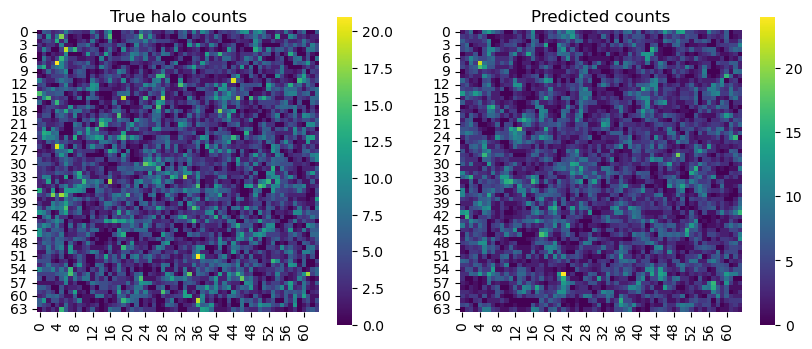

In [40]:
# Plot some heatmaps of the predictions, by reading them in the new data file, to checks if they were added correctly:
seed_id = 9
reskey_id = 1
field_id = 1
seed = av_seeds[seed_id]

f = h5py.File(pred_file, mode='r')
group = f[seed]
reskey = "res_{}".format(reskey_id)
gt_counts = group[reskey]["counts_bin_{}".format(field_id)][:]
pred_counts = group[reskey]["counts_predicted_bin_{}".format(field_id)][:]
N = np.shape(gt_counts)[0]
f.close()

plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.heatmap(gt_counts[...,N//2], cmap="viridis")
ax = plt.gca()
ax.set_aspect('equal')
plt.title("True halo counts")
plt.subplot(122)
sns.heatmap(pred_counts[...,N//2], cmap="viridis")
ax = plt.gca()
ax.set_aspect('equal')
plt.title("Predicted counts")
plt.show()